# Bechmark: Vern9 vs IRKGL16 (BigFloat128) 

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Initial-value-problem:-Burrau-problem">
             Initial value problem: Burrau problem</a></li>

<li><a href="#Integration-with-Vern9">
             Integration with Vern9</a></li>
             
<li><a href="#Integration-with-IRKGL16-(Adaptive-step)">
             Integration with IRKGL16 (Adaptive-step)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  


## Loading packages

In [1]:
using Pkg
using IRKGaussLegendre,LinearAlgebra,Plots,Statistics
using OrdinaryDiffEq, BenchmarkTools,DiffEqDevTools

In [2]:
BenchmarkTools.DEFAULT_PARAMETERS.samples=10

10

https://juliamath.github.io/DoubleFloats.jl/v0.8/#More-Performant-Than-BigFloat-1

Comparing Double64 and BigFloat after setting BigFloat precision to 106 bits.

In [3]:
setprecision(BigFloat, 106)
(typeof(big(0.0)), precision(big(0.0)))

(BigFloat, 106)

<a href="#top">Back to the top</a>

## Initial value problem: Burrau problem

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [4]:
include("../examples/InitialBurrau.jl")
u0, Gm =InitialBurrau(BigFloat)
N = length(Gm)
(size(u0), typeof(u0), typeof(Gm))

((2, 3, 3), Array{BigFloat,3}, Array{Int64,1})

Just to check that the output of the function NbodyODE has the expected type:

In [5]:
include("../examples/Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
@show size(du0);

size(du0) = (2, 3, 3)


In [6]:
t0 = big(0.)
T = big(63.)  # Final time
dt = BigFloat(10^(-4)) # time-step length

tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

<a href="#top">Back to the top</a>


## Integration with Vern9

Recommend methods: Non-Stiff Problems

- For high accuracy non-stiff solving ( BigFloat and tolerances like <1e-12 ), JuliaDiffeq recommend
the Vern9 method


In [7]:
sol0 = @btime(solve(prob,Vern9(),saveat=0.1, abstol=1e-12,reltol=1e-12));

  5.632 s (55198975 allocations: 2.58 GiB)


In [8]:
sol0.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  69650
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          3729
Number of rejected steps:                          624

## Integration with IRKGL16 (Adaptive-step)


In [9]:
(sol1,iters1,steps1)=@btime(solve(prob,IRKGL16(), reltol=1e-12, abstol=1e-12,myoutputs=true));

  8.523 s (97236097 allocations: 4.48 GiB)


In [10]:
mean(iters1)

10.0

In [11]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  93614
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          1073
Number of rejected steps:                          97

## Integration with IRKGL162 (Adaptive-step)

In [12]:
(sol2,iters2,steps2)=@btime(solve(prob,IRKGL162(), reltol=1e-12, abstol=1e-12,myoutputs=true));

  17.134 s (204170760 allocations: 9.40 GiB)


In [13]:
mean(iters2)

22.34078212290503

In [14]:
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  197175
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          1073
Number of rejected steps:                          99

### Plots IRKGL16

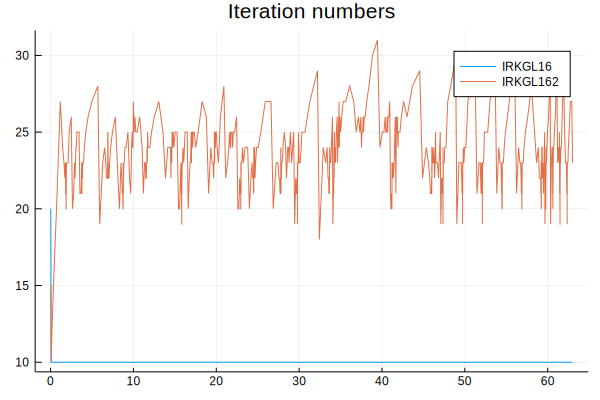

In [15]:
plot(sol1.t[2:end],iters1[2:end], title="Iteration numbers", label="IRKGL16")
plot!(sol2.t[2:end],iters2[2:end],label="IRKGL162")

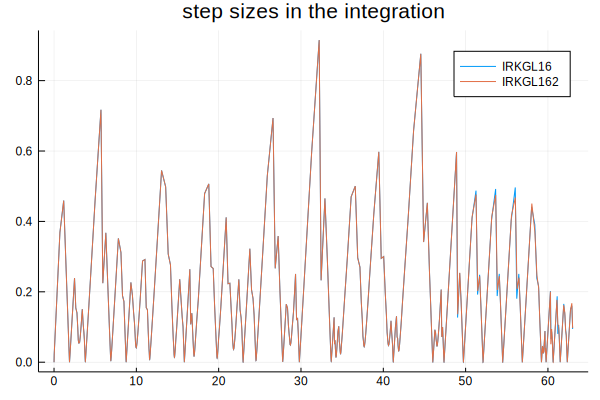

In [16]:
plot(sol1.t,steps1, title="step sizes in the integration", label="IRKGL16")
plot!(sol2.t,steps2,label="IRKGL162")

### Plots

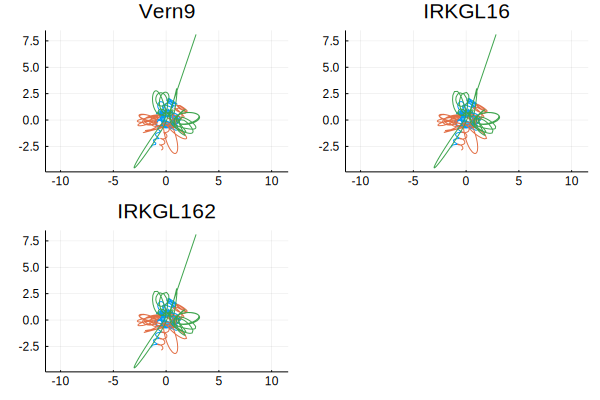

In [17]:
bodylist = ["Body-1", "Body-2", "Body-3"]
ulist0 = sol0.u
tlist0 = sol0.t

pl1 = plot(title="Vern9",aspect_ratio=1)

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl1 = plot!(xlist,ylist, label="") # label = bodylist[j])   
end    


pl2 = plot(title="IRKGL16",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl2 = plot!(xlist,ylist,label="") # label = bodylist[j])   
end  


pl3 = plot(title="IRKGL162",aspect_ratio=1)

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist2)
 ylist  = map(u->u[2,2,j], ulist2)
 pl3 = plot!(xlist,ylist,label="") # label = bodylist[j])   
end  

#plot(pl)
plot(pl1,pl2,pl3, layout=3)

In [18]:
plot(pl2)
savefig("Burrau.png")

<a href="#top">Back to the top</a>

## Error in energy

In [19]:
setprecision(BigFloat, 256)
u0128, Gm =InitialBurrau(BigFloat)
(typeof(u0128),typeof(Gm))

(Array{BigFloat,3}, Array{Int64,1})

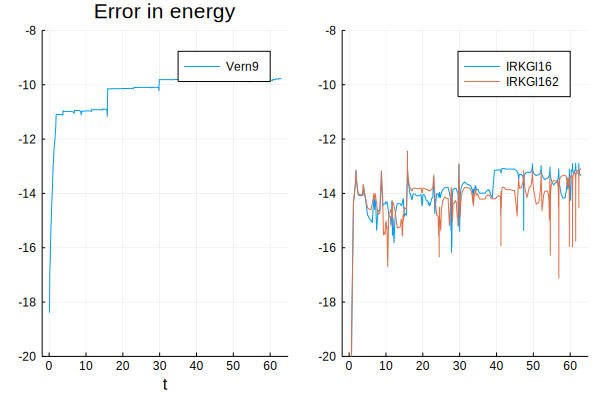

In [20]:
E0=NbodyEnergy(u0128,Gm)
end1=length(steps1)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol0.u[j]),Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),Gm)/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]
EnergyErrors2=[NbodyEnergy(BigFloat.(sol2.u[j]),Gm)/E0-1 for j in 1:length(tlist2)]

ylimit1=-20
ylimit2=-8

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl16")
p2=plot!(tlist2[1:end],log10.(abs.(EnergyErrors2)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl162")
plot(p1,p2,layout=2)

In [21]:
(Float32(maximum(abs.(EnergyErrors))),Float32(maximum(abs.(EnergyErrors1))),Float32(maximum(abs.(EnergyErrors2))))

(1.6790212f-10, 3.6568006f-13, 3.7014573f-13)

## Global errror

In [22]:
setprecision(BigFloat, 106)
u0128, Gm =InitialBurrau(BigFloat)
tspan128=(BigFloat(t0),BigFloat(T))
prob128=ODEProblem(NbodyODE!,u0128,tspan128,Gm);

In [23]:
sol = solve(prob128,Vern9(),save_everystep=false,abstol=1e-24,reltol=1e-24);
test_sol = TestSolution(sol);

In [24]:
ulist = sol.u
tlist = sol.t
DErrors=[NbodyEnergy(BigFloat.(sol.u[j]),Gm)/E0-1 for j in 1:length(tlist)]
DErrors[end]

4.11516181021079395457510196440589e-22

In [25]:
# Vern9
apr = appxtrue(sol0,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 11.8734878000923590970431649267385,:L2 => 1.90013610471961675560176358333734,:final => 0.00105965365691785916496615506687681,:l2 => 1.90840552310388551791302264512974,:L∞ => 11.8663294939196601322174309251633)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 11.8735
  :L2    => 1.90014
  :final => 0.00105965
  :l2    => 1.90841
  :L∞    => 11.8663

In [26]:
# IRGL16
apr = appxtrue(sol1,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 113.838529069554194951088106737948,:L2 => 1.90152833291278217987805844322932,:final => 2.18976988339014513904468036487951e-06,:l2 => 5.01172868357945012126153727404408,:L∞ => 11.8663054320217275945000650291159)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 113.839
  :L2    => 1.90153
  :final => 2.18977e-06
  :l2    => 5.01173
  :L∞    => 11.8663

In [27]:
# IRGL162
apr = appxtrue(sol2,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 113.838527444277912448363804362031,:L2 => 1.90148623405461675990834946881921,:final => 1.2778645147614749936361148747079e-06,:l2 => 5.01199098145977044550062932447028,:L∞ => 11.8662088779481738672725657055381)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 113.839
  :L2    => 1.90149
  :final => 1.27786e-06
  :l2    => 5.01199
  :L∞    => 11.8662

In [28]:
err0=Float32(norm(sol0.u[end]-sol.u[end]))
err1=Float32(norm(sol1.u[end]-sol.u[end]))
err2=Float32(norm(sol2.u[end]-sol.u[end]))
(err0,err1,err2)

(0.008302194f0, 1.715986f-5, 1.0013828f-5)